In [1]:
import hydra

from shared_lib.enums import RunMode
from shared_lib.utils.utils_vis import save_plot

In [2]:
with hydra.initialize_config_module(config_module="analyzer.nodule_attr.configs", version_base=None):
    config = hydra.compose(config_name="config_inference", overrides=[])

/opt/conda/lib/python3.10/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'config_inference': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)


In [3]:
# runner
models = dict()
for model_indicator, config_model in config.models.items():
    models[model_indicator] = hydra.utils.instantiate(config_model)
processor = hydra.utils.instantiate(config.processor, models=models)

In [4]:
# run modes
run_modes = [RunMode(m) for m in config.run_modes] if "run_modes" in config else [x for x in RunMode]

In [5]:
# loader
loaders = {
    mode: hydra.utils.instantiate(
        config.loader,
        dataset={"mode": mode},
        drop_last=(mode == RunMode.TRAIN),
        shuffle=(mode == RunMode.TRAIN),
    )
    for mode in run_modes
}

/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.7'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [6]:
TARGET_INDEX = 2
for i, data in enumerate(loaders[RunMode.TEST]):
    if i == TARGET_INDEX:
        patch_image = data["image"]
        output = processor.predict_given_patch(patch_image)
        break

In [7]:
mask = output["c_segmentation_logistic"]

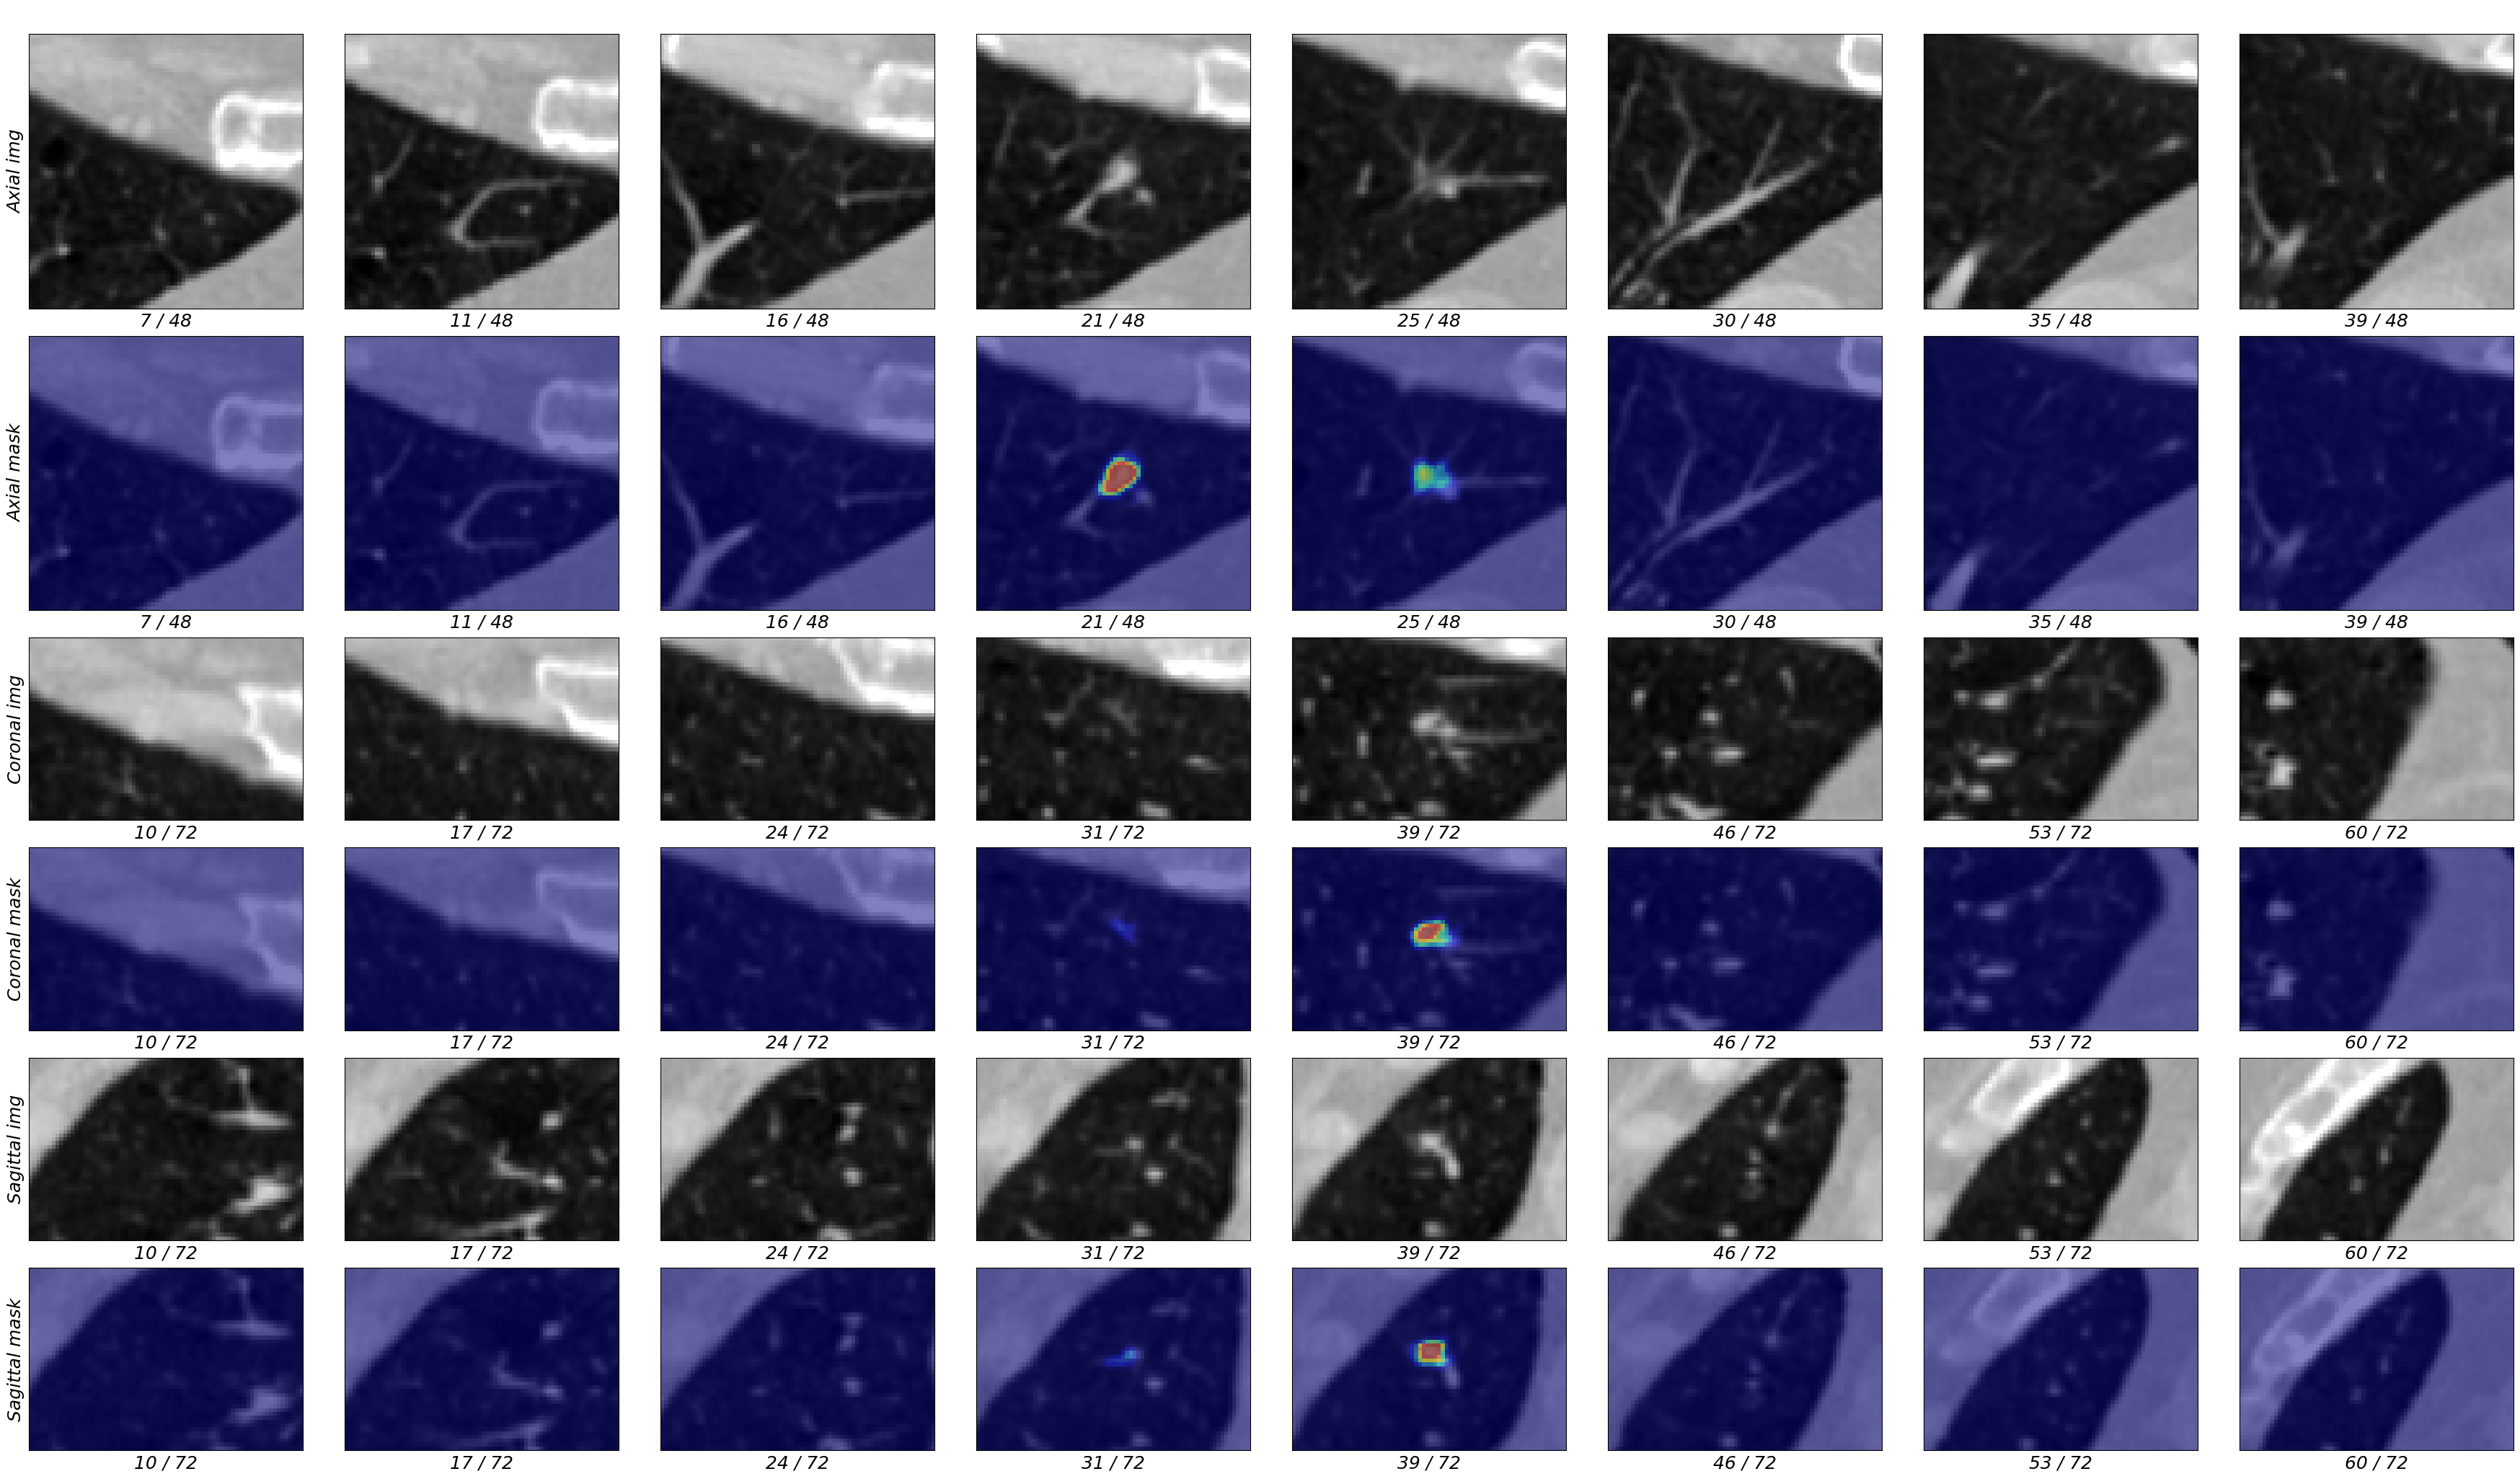

In [8]:
# save visualization result
figure_title = ""
attr = {}

patch = patch_image[0].squeeze().detach().cpu().numpy()
mask = mask[0].squeeze().detach().cpu().numpy()
save_plot(
    input_image=patch,
    mask_image=mask,
    nodule_zyx=None,
    figure_title=figure_title,
    meta=attr,
    use_norm=False,
    save_dir=None,
    dpi=60,
)